# Visual Search

## Imports

In [1]:
# General Use
import csv
import sys
#import requests
import skimage.io
import os
import glob
import pickle
from IPython.display import display, Image, HTML
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
import cv2
import h5py
import json
import datetime
import time

# TensorFlow
#import tensorflow as tf


os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

In [48]:
# Keras imports
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50 
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetMobile
from keras.preprocessing import image
from keras.models import Model
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.utils import multi_gpu_model

The configuration file points to the Watchfinder dataset.

In [3]:
# load the user configs
with open('conf/conf.json') as f:    
  config = json.load(f)

# config variables
model_name    = config["model"]
weights     = config["weights"]
include_top   = config["include_top"]
train_path    = config["train_path"]
features_path   = config["features_path"]
labels_path   = config["labels_path"]
test_size     = config["test_size"]
results     = config["results"]
model_path    = config["model_path"]

# start time
print ("[STATUS] start time - {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M")))
start = time.time()

[STATUS] start time - 2019-10-05 01:05


## Pick a pre-trained network
In this case we pick VGG16: it is simple and fast enough for the dataset in use.  
We cut it at the layer before the final classifier and create our own model version.

In [4]:
base_model = VGG16(weights=weights)
model = Model(input=base_model.input, output=base_model.get_layer('fc1').output)
image_size = (224, 224)

INFO:plaidml:Opening device "metal_amd_radeon_pro_455.0"
/Users/gmarchetti/anaconda3/envs/plaidml/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=input_1 Pl..., outputs=Relu FLOAT...)`
  


## Extract features and encode labels
We wun the pictures through the network and associate each feature set to its class.

In [5]:
# path to training dataset
train_labels = os.listdir(train_path)

# encode the labels
print ("[INFO] encoding labels...")
le = LabelEncoder()
le.fit([tl for tl in train_labels])

# variables to hold features and labels
features = []
labels   = []
file_map=[]

# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
  cur_path = train_path + "/" + label
  count = 1
  for image_path in glob.glob(cur_path + "/*.jpg"):
    try:
      img = image.load_img(image_path, target_size=image_size)
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      # extract features  
      feature = model.predict(x)
      flat = feature.flatten()
      features.append(flat)
      labels.append(label)
      file_map.append(image_path)  
      print ("[INFO] processed - " + str(count))
      count += 1
    except:
      pass
  print ("[INFO] completed label - " + label)

# encode the labels using LabelEncoder
le = LabelEncoder()
le_labels = le.fit_transform(labels)

# get the shape of training labels
print ("[STATUS] training labels: {}".format(le_labels))
print ("[STATUS] training labels shape: {}".format(le_labels.shape))

[INFO] encoding labels...
[INFO] processed - 1
[INFO] processed - 2
[INFO] processed - 3
[INFO] processed - 4
[INFO] processed - 5
[INFO] processed - 6
[INFO] processed - 7
[INFO] processed - 8
[INFO] processed - 9
[INFO] processed - 10
[INFO] processed - 11
[INFO] processed - 12
[INFO] processed - 13
[INFO] processed - 14
[INFO] processed - 15
[INFO] processed - 16
[INFO] processed - 17
[INFO] processed - 18
[INFO] processed - 19
[INFO] processed - 20
[INFO] processed - 21
[INFO] processed - 22
[INFO] processed - 23
[INFO] processed - 24
[INFO] processed - 25
[INFO] processed - 26
[INFO] processed - 27
[INFO] processed - 28
[INFO] processed - 29
[INFO] processed - 30
[INFO] processed - 31
[INFO] processed - 32
[INFO] processed - 33
[INFO] processed - 34
[INFO] processed - 35
[INFO] processed - 36
[INFO] processed - 37
[INFO] processed - 38
[INFO] processed - 39
[INFO] processed - 40
[INFO] processed - 41
[INFO] processed - 42
[INFO] processed - 43
[INFO] processed - 44
[INFO] processe

In [6]:
features=np.vstack(features)

In [7]:
print (features)

[[0.         1.2587396  0.         ... 0.         0.47966772 0.        ]
 [0.         1.4021232  0.         ... 0.         0.55615115 0.        ]
 [0.         1.2698712  0.         ... 0.         0.22047772 0.        ]
 ...
 [0.         1.5204707  0.         ... 0.         0.24350347 0.        ]
 [0.         1.5916742  0.         ... 0.         0.5306608  0.        ]
 [0.         1.5639738  0.         ... 0.         0.5433903  0.        ]]


## Compute distances
We'll pick a query image, then compute cosine, euclidean and Hamming distances among it and the rest of the dataset.

watches/train/10071/45224411036303.jpg


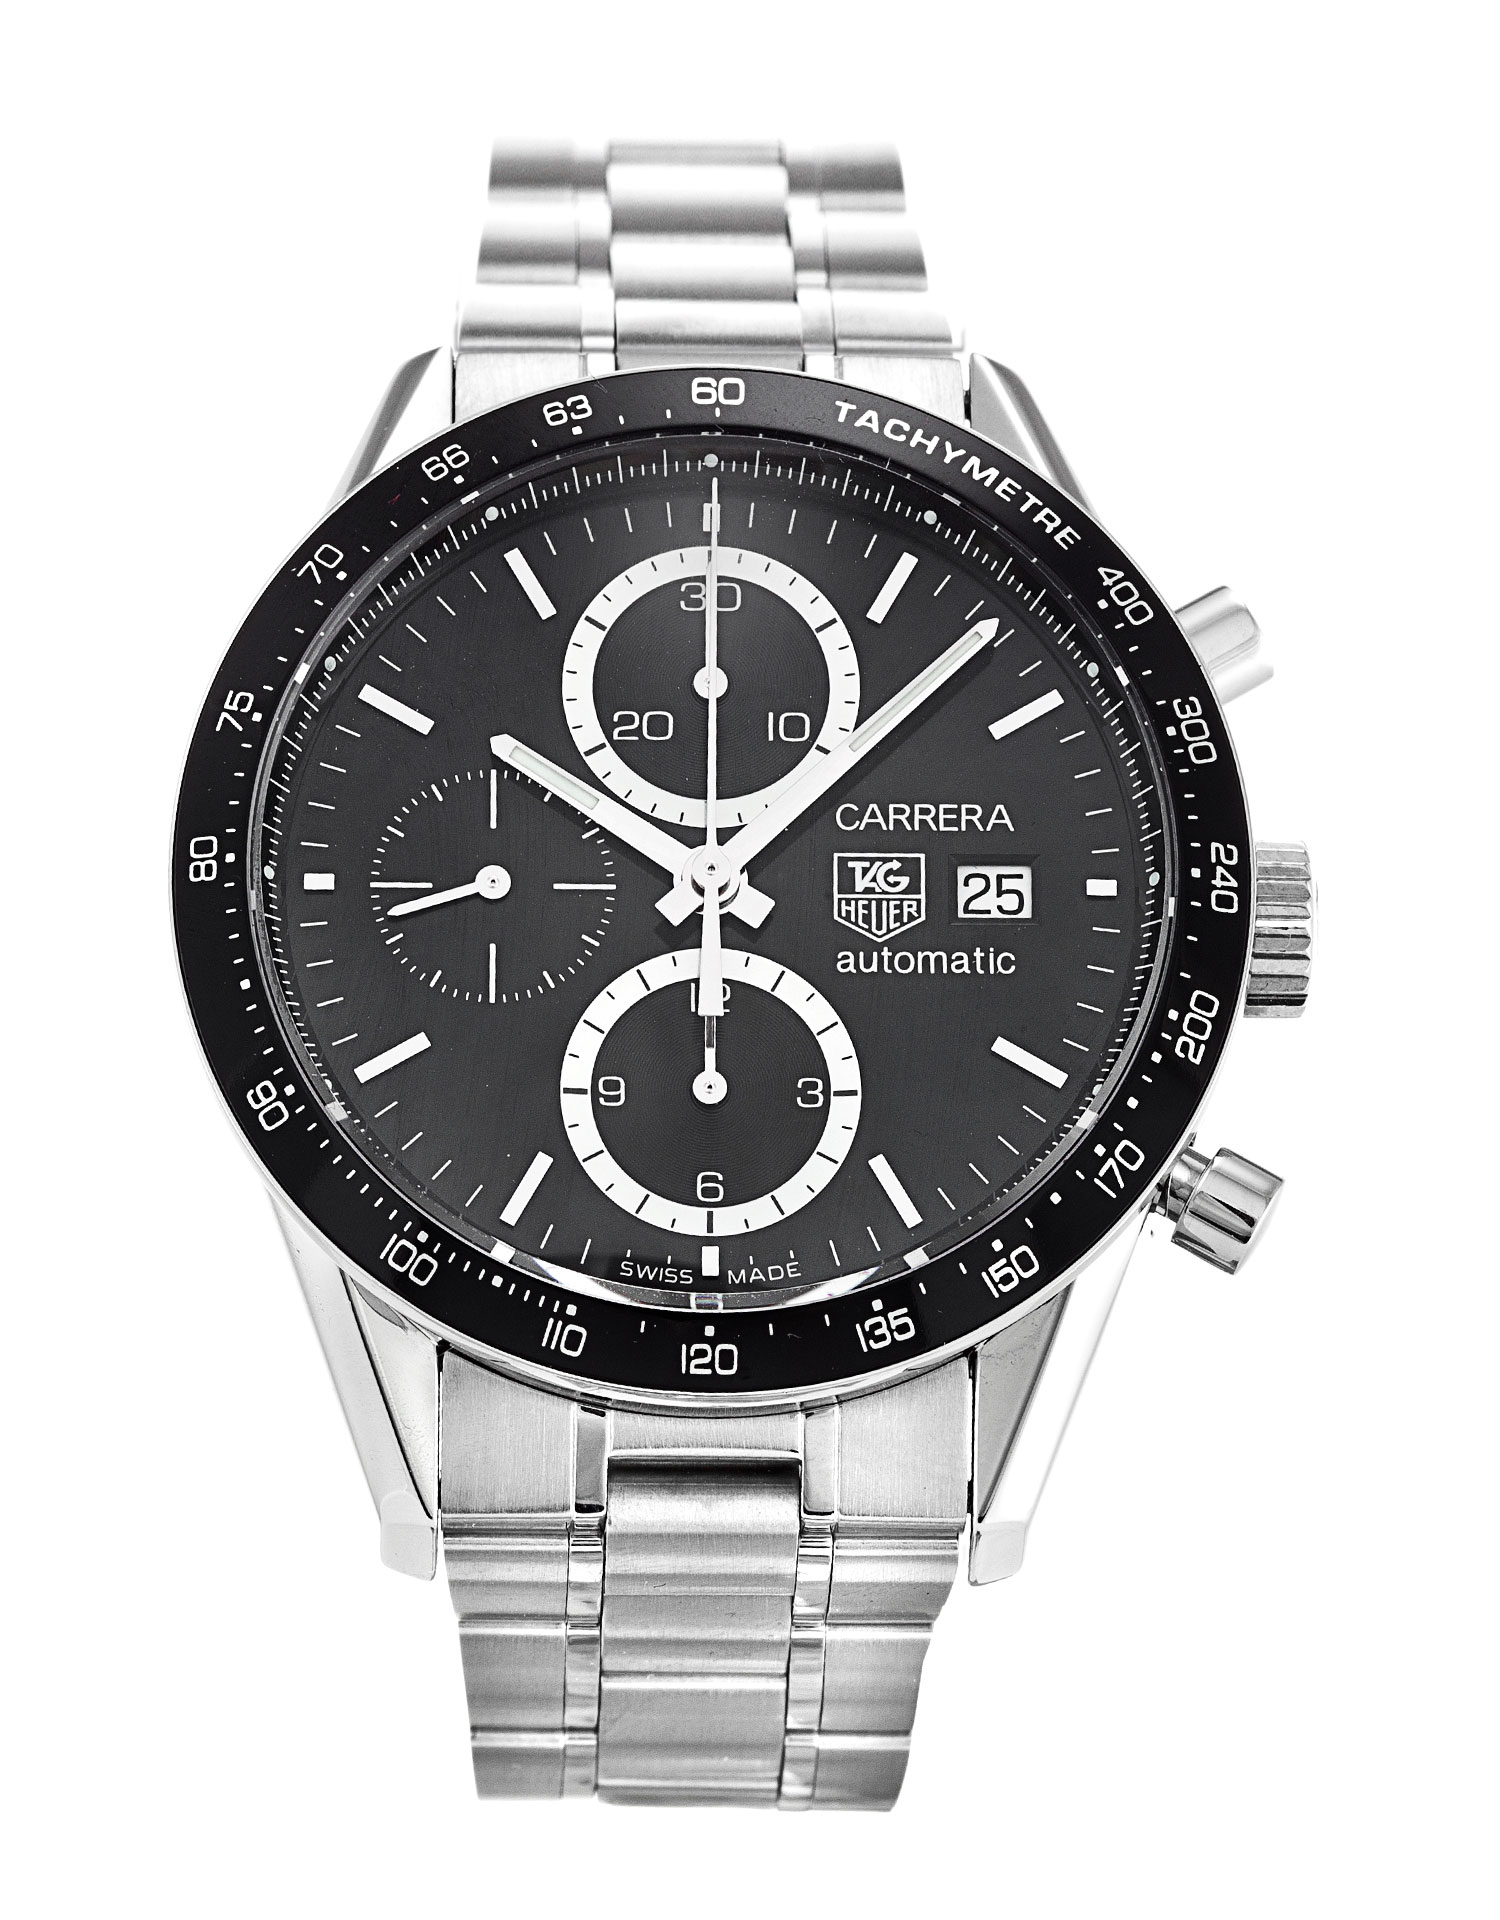

In [8]:
idx=1001
print(file_map[idx])
Image(file_map[idx])

In [9]:
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(features[idx,:].reshape(1,-1), features, metric='cosine')

In [10]:
print(distances)

[[0.01643848 0.01791418 0.01542592 ... 0.01742804 0.01850855 0.01961112]]


Pick the 9 closest images

In [11]:
indices=np.argsort(distances)[0][:9]

In [12]:
def Display_Images(images, header=None, width="100%"): # to match Image syntax
    if type(width)==type(1): width = "{}px".format(width)
    html = ["<table style='width:{}'><tr>".format(width)]
    if header is not None:
        html += ["<th>{}</th>".format(h) for h in header] + ["</tr><tr>"]

    cols=1
    for image in images:
        print(image)
        html.append("<td><img src='{}' /></td>".format(image))
        cols+=1
        if (cols>3):
            html.append("</tr><tr>")
            cols=1
    html.append("</tr></table>")
    display(HTML(''.join(html)))

In [13]:
Display_Images([file_map[i] for i in indices],width="100%")

watches/train/10071/45224411036303.jpg
watches/train/10071/44596-1709844998.jpg
watches/train/10071/41788-1240797980.jpg
watches/train/10071/44625-186045323.jpg
watches/train/10071/503841583428086.jpg
watches/train/10071/48737-555214023.jpg
watches/train/2578/45849-1020484409.jpg
watches/train/10071/43585106780825.jpg
watches/train/10071/458921287512871.jpg


In [14]:
distances = pairwise_distances(features[idx,:].reshape(1,-1), features, metric='euclidean')

In [15]:
print(distances)

[[16.659563 17.28147  16.03719  ... 17.016691 17.545502 18.093128]]


In [16]:
indices=np.argsort(distances)[0][:9]

In [17]:
Display_Images([file_map[i] for i in indices],width="100%")

watches/train/10071/45224411036303.jpg
watches/train/10071/44596-1709844998.jpg
watches/train/10071/41788-1240797980.jpg
watches/train/10071/44625-186045323.jpg
watches/train/10071/503841583428086.jpg
watches/train/10071/48737-555214023.jpg
watches/train/2578/45849-1020484409.jpg
watches/train/10071/43585106780825.jpg
watches/train/10071/458921287512871.jpg


In [18]:
hdistances = pairwise_distances(features[idx,:].reshape(1,-1), features, metric='hamming')

In [19]:
print(hdistances)

[[0.73876953 0.73144531 0.72973633 ... 0.72241211 0.72900391 0.72875977]]


In [20]:
hindices=np.argsort(hdistances)[0][:9]

In [21]:
Display_Images([file_map[i] for i in hindices],width="100%")

watches/train/10071/45224411036303.jpg
watches/train/10071/44596-1709844998.jpg
watches/train/10071/48283-1965108219.jpg
watches/train/9673/507981148470846.jpg
watches/train/10071/38659-1815758436.jpg
watches/train/10071/48737-555214023.jpg
watches/train/10071/45792-2106180426.jpg
watches/train/9673/46775-235228718.jpg
watches/train/10071/42920523712132.jpg


In [22]:
np.amax(features)

8.764365

Create a binary code explicitly

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
print(scaler.fit(features))
scaled_features=scaler.transform(features)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [24]:
binary_features = (scaled_features<0.5).astype(int)
print(binary_features)

[[1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 ...
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 1 1 1]]


In [25]:
scaled_query=scaler.transform(features[idx,:].reshape(1,-1))
binary_query=(scaled_query<0.5).astype(int)
print(binary_query)

[[1 1 1 ... 1 0 1]]


In [26]:
hdistances2 = pairwise_distances(binary_query, binary_features, metric='hamming')

In [27]:
print(hdistances2)

[[0.28344727 0.28637695 0.26708984 ... 0.28613281 0.29907227 0.30541992]]


In [28]:
hindices=np.argsort(hdistances)[0][:9]

In [29]:
Display_Images([file_map[i] for i in hindices],width="100%")

watches/train/10071/45224411036303.jpg
watches/train/10071/44596-1709844998.jpg
watches/train/10071/48283-1965108219.jpg
watches/train/9673/507981148470846.jpg
watches/train/10071/38659-1815758436.jpg
watches/train/10071/48737-555214023.jpg
watches/train/10071/45792-2106180426.jpg
watches/train/9673/46775-235228718.jpg
watches/train/10071/42920523712132.jpg


# Semantic Hashing
Now let us try with the deep fashion dataset http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion.html  
We will add a layer for 64-bit semantic hashing, i.e. to characterize each image with a 64-bit number.  
There is no "binary" activation function, so we'll approximate with tanh and then do some postprocessing.  
64 bit is current limitation of MySQL bit() type on mysql5.7, which we want to use in azure to offload search.


## Files Preprocessing
We move the data into directories reflecting the 46 categories, then split into train and test.  
Pretty boring - not much to see

In [30]:
#prepare directory structures
# path to training dataset
img_path='./fashion_data/img'
train_path='./fashion_data/imgtrain'

# Copy images into fundamental categories structure
import os
source = img_path
dest = train_path
dirs = os.listdir(source)
import shutil
import numpy as np
for d in dirs:
    files=os.listdir(os.path.join(source,d))
    #print (len(files))
    #if len(files)>50:
        
    newdir = d.rsplit('_',1)[1]
    print (d.rsplit('_',1)[1])
    newdest=dest+'/'+newdir
    if not os.path.exists(newdest):
                os.mkdir(newdest)   

    for f in files:
        #try:
            full_file_name = os.path.join(d, f)

            target_file_name=os.path.join(newdest,f)
            if os.path.exists(target_file_name):
                target_file_name = os.path.splitext(target_file_name)[0]+'_'+time.strftime("%Y%m%d-%H%M%S")+os.path.splitext(target_file_name)[1]

            print(source+'/'+full_file_name)
            print(target_file_name)

            shutil.copy(source+'/'+full_file_name, target_file_name)
        #except:
        #    pass

NotADirectoryError: [WinError 267] The directory name is invalid: './fashion_data/img\\.7z'

In [ ]:
#move some images to test directory
# path to training dataset
from math import floor
import random
import shutil

train_path='./fashion_data/imgtrain'
test_path='./fashion_data/imgtest'

#move some images for testing
source = train_path
dest = test_path
dirs = os.listdir(source)
count=0
for d in dirs:
    print(d)
    count +=1
    print(count)
    if ('.DS_Store' not in d):
        files=os.listdir(os.path.join(source,d))
        #select 10% random items        
        for f in random.sample(files,floor(len(files)*0.1)):
            #try:

                full_file_name = os.path.join(d, f)
                print (full_file_name)
                if not os.path.exists(dest+'/'+d):
                    os.mkdir(dest+'/'+d)
                print(source+'/'+full_file_name)
                print(dest+'/'+full_file_name)
                #fore some reason move does not work - it causes a filename does not exist...
                shutil.move(source+'/'+full_file_name, dest+'/'+full_file_name)                
            #except:
            #    pass

## Create Datasets for Model
We use the ImageDataGenerator class to create a training, test and validation dataset by iterating over our directory structure. Each directory name is a label.  
We also take advantage of some of the image processing features to introduce some "randomness" to make the classification more robust.

In [30]:
from keras.preprocessing.image import ImageDataGenerator
train_path='./fashion_data/img/train'
test_path='./fashion_data/img/val'

train_datagen = ImageDataGenerator(
    rotation_range=30.,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
    #samplewise_center=True,
    #samplewise_std_normalization=True
        #rescale=1./255
)

test_datagen = ImageDataGenerator(
    #samplewise_center=True,
    #samplewise_std_normalization=True
    #rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 209215 images belonging to 46 classes.
Found 39999 images belonging to 46 classes.


In [31]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping,ReduceLROnPlateau
from keras.layers import Activation, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam, rmsprop

In [59]:
# Now let us try with deep fashion dataset and add a layer for 64-bit semantic hashing
# 64 bit is current limitation of MySQL bit() type on mysql5.7, which we want to use in azure to offload search
#base_model = InceptionV3(weights='imagenet', include_top=False)
#base_model.summary()
#image_size = (299, 299)

# add a global spatial average pooling layer
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
base_model = NASNetMobile(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))
#encoder=Flatten()(model.output)
#x=base_model.get_layer(base_model.layers[-2].name).output
#for layer in base_model.layers:
#    layer.trainable=False
x=base_model.output
#x=Flatten()(x)
#x=Dense(256,activation='relu',name='encoder')(x)
#x=Dropout(0.3)(x)
#x=Dense(256,activation='relu')(x)
x=Dense(64, name='hash')(x)
#x=BatchNormalization()(x)
x=Activation('hard_sigmoid',name='hash-out')(x)
#x=Dense(2048, name='decoder', activation='relu')(x)
predictions=Dense(46, activation='softmax')(x)

#for layer in base_model.layers[:-12]:
#    layer.trainable=False

#create graph of your new model
G=1
if G>1:
    with tf.device("/cpu:0"):
        model = Model(input = base_model.input, output = predictions)
    print("Training with {} GPUs".format(G))
    model=multi_gpu_model(model, gpus=G)
else:
    model = Model(input = base_model.input, output = predictions)

#compile the model
#sgd=SGD(lr=0.0001, momentum=0.5, nesterov=False)
adam=Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()    


/Users/gmarchetti/anaconda3/envs/plaidml/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=flatten_5/..., outputs=Softmax FL...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_8[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_712 (Activation)     (None, 111, 111, 32) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

In [ ]:
base_model.summary()

In [ ]:
# as of version 1.7 tensorboard consumes gpu. we don't want that
tb=TensorBoard()
tb.set_model(model)
tb.log_dir

In [60]:
# bag of tricks to control the gradient descent
# reduce the learning rate on plateaus
lr_reducer = ReduceLROnPlateau(monitor='val_acc',
                               patience=5,
                               factor=0.2,
                               cooldown=1,
                               verbose=1)
#tensorboard = TensorBoard(log_dir='./logs')
# stop if valuation accuracy plateaus 
early_stopper = EarlyStopping(monitor='val_acc',
                              patience=11,
                              verbose=1)
# save the model at every improvement
checkpoint = ModelCheckpoint("Resnet50_encoder2048_hash64_5slow.h5", 
                             monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)

In [61]:
print(len(train_generator), len(validation_generator))

6538 1250


## Training
For time's sake, we can reduce the number of steps per epoch, but that is going to cost us in valuation accuracy as we're going to leave a subset of pictures "unseen"

In [62]:
history=model.fit_generator(
    train_generator,
    steps_per_epoch=2200,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=420,
    callbacks=[ #lr_reducer,
               early_stopper, 
               checkpoint
               #tb
              ],
    workers=4,
    shuffle=True
)

Epoch 1/200


INFO:plaidml:Analyzing Ops: 549 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 1516 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 2479 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 3426 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 4654 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 5790 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 7166 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 8226 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 9378 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 10114 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 11726 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 14766 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 17729 of 24010 operations complete
INFO:plaidml:Analyzing Ops: 20738 of 24010 operations complete


2199/2200 [============================>.] - ETA: 9s - loss: 1.7960 - acc: 0.4877 

INFO:plaidml:Analyzing Ops: 695 of 2952 operations complete
INFO:plaidml:Analyzing Ops: 1809 of 2952 operations complete


2200/2200 [==============================] - 21694s 10s/step - loss: 1.7960 - acc: 0.4877 - val_loss: 2.7088 - val_acc: 0.2714

Epoch 00001: val_acc improved from -inf to 0.27143, saving model to Resnet50_encoder2048_hash64_5slow.h5
Epoch 2/200
1512/2200 [===================>..........] - ETA: 1:51:36 - loss: 1.5402 - acc: 0.5571

KeyboardInterrupt: 

In [ ]:
model.save('resnet50_hash64.h5')

## Test 
We test on a different subset and compute metrics

In [13]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
        "./fashion_data/img/test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

scores = model.evaluate_generator(test_generator, verbose=1)
print (model.metrics_names)
print (scores)



Found 39998 images belonging to 46 classes.
1250/1250 [==============================] - 74s 59ms/step
['loss', 'acc']
[1.099806762732913, 0.6902845142406132]


## Featurize
We calculate the hash codes of our catalog by running the pictures through the tuned network

In [14]:
hash_model=Model(input=model.input, output=model.get_layer('hash-out').output)


C:\Anaconda\envs\DL2\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ha...)`
  """Entry point for launching an IPython kernel.


In [15]:
hash_model.predict_generator(test_generator, verbose=1)

1250/1250 [==============================] - 75s 60ms/step


array([[0.47615156, 0.05740228, 0.87068355, ..., 0.186793  , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.        , 1.        ,
        1.        ],
       [0.30195633, 1.        , 0.79281044, ..., 0.26903662, 1.        ,
        1.        ],
       ...,
       [0.28221056, 1.        , 0.        , ..., 1.        , 0.3121659 ,
        1.        ],
       [1.        , 0.8578851 , 1.        , ..., 0.31286734, 1.        ,
        1.        ],
       [1.        , 0.58684343, 0.11771813, ..., 0.8900416 , 0.5025058 ,
        0.7710322 ]], dtype=float32)

In [16]:
# path to training dataset
train_path='./fashion_data/img/test'
train_labels = os.listdir(train_path)
image_size = (224, 224)
print ("[INFO] encoding image hashes...")

def binarize (a_list):
    b=''.join(str(e) for e in a_list)
    return int(b,2)

# variables to hold features and labels

features = []
labels   = []
file_map=[]
table=pd.DataFrame(columns=['id', 'path', 'label', 'code'])
                            
# loop over all the labels in the folder
count = 1
for i, label in enumerate(train_labels):
    cur_path = train_path + "/" + label 
    print(cur_path)
    for image_path in glob.glob('{}/**/*.jpg'.format(cur_path), recursive=True):
        #try:
            img = image.load_img(image_path, target_size=image_size)
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            #generate hash using hash model
            hash_out = hash_model.predict(x)
            # a very crude way to generate a binary number, but effective
            bin_out = np.where(hash_out.flatten()>0.5,1,0)           
            features.append(bin_out)  
            labels.append(label)
            file_map.append(image_path)
            num_out=binarize(bin_out)
            print (image_path, num_out)
            table=table.append(pd.DataFrame(data=[[count, image_path, label, num_out]], columns=['id', 'path', 'label', 'code']), ignore_index=True)
            print ("[INFO] processed - " + str(count))
            count += 1
        #except:
        #    pass
    print ("[INFO] completed label - " + label)
    
    

[INFO] encoding image hashes...
./fashion_data/img/test/Anorak
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000005.jpg 87103242766074772
[INFO] processed - 1
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000008.jpg 105126468293184404
[INFO] processed - 2
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000015.jpg 105117109492337556
[INFO] processed - 3
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000018.jpg 105117113795691412
[INFO] processed - 4
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000019.jpg 105117109504918420
[INFO] processed - 5
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000026.jpg 105117109492337557
[INFO] processed - 6
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000029.jpg 105117113799885716
[INFO] processed - 7
./fashion_data/img/test/Anorak\Hooded_Cotton_Canvas_Anorak\img_00000038.jpg 9310474752132596628
[INFO] processed - 8
./fashion

In [ ]:
print(table)

In [1]:
import mysql.connector
from mysql.connector import errorcode

# Obtain connection string information from the portal
config = {
  'host':'gmmysql.mysql.database.azure.com',
  'user':'gmarchetti@gmmysql',
  'password':'ScienceGuy1!',
  'database':'vsdb'
}


import sqlalchemy
database_username = 'gmarchetti@gmmysql'
database_password = 'ScienceGuy1!'
database_ip       = 'gmmysql.mysql.database.azure.com'
database_name     = 'vsdb'
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [18]:
table.to_sql(con=database_connection, name='imagedata', if_exists='replace')    
    

In [25]:
#query to select top 9 with hamming distance from given hash

from sqlalchemy import text
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

sql = text('SELECT id, path, label, BIT_COUNT(105117672137245588 ^ code)  as hd FROM imagedata ORDER BY hd ASC limit 9;')
result = database_connection.engine.execute(sql)
print(result)

file_map=[]
for row in result:
    print (row)
    file_map.append(row[1])



(71, './fashion_data/img/test/Blazer\\Button-Front_Blazer\\img_00000063.jpg', 'Blazer', 0)
(148, './fashion_data/img/test/Blazer\\Classic_One-Button_Blazer\\img_00000050.jpg', 'Blazer', 0)
(186, './fashion_data/img/test/Blazer\\Classic_Two-Button_Blazer\\img_00000095.jpg', 'Blazer', 0)
(239, './fashion_data/img/test/Blazer\\Collarless_One-Button_Blazer\\img_00000080.jpg', 'Blazer', 0)
(536, './fashion_data/img/test/Blazer\\Knit_Open-Front_Blazer\\img_00000012.jpg', 'Blazer', 0)
(677, './fashion_data/img/test/Blazer\\Oversized_Open-Front_Blazer\\img_00000005.jpg', 'Blazer', 0)
(794, './fashion_data/img/test/Blazer\\Single-Button_Blazer\\img_00000074.jpg', 'Blazer', 0)
(949, './fashion_data/img/test/Blazer\\Tweed_Boyfriend_Blazer\\img_00000123.jpg', 'Blazer', 0)
(960, './fashion_data/img/test/Blazer\\Two-Button_Blazer\\img_00000044.jpg', 'Blazer', 0)


We picked a blazer. The catalog contains several categories. So far, the algorithm has at least identified that it is a blazer. However, you can see that several have distance 0. Our 64-bit binarization algorithm loses quite a bit of resolution.

In [26]:
Display_Images(file_map,width="100%")

./fashion_data/img/test/Blazer\Button-Front_Blazer\img_00000063.jpg
./fashion_data/img/test/Blazer\Classic_One-Button_Blazer\img_00000050.jpg
./fashion_data/img/test/Blazer\Classic_Two-Button_Blazer\img_00000095.jpg
./fashion_data/img/test/Blazer\Collarless_One-Button_Blazer\img_00000080.jpg
./fashion_data/img/test/Blazer\Knit_Open-Front_Blazer\img_00000012.jpg
./fashion_data/img/test/Blazer\Oversized_Open-Front_Blazer\img_00000005.jpg
./fashion_data/img/test/Blazer\Single-Button_Blazer\img_00000074.jpg
./fashion_data/img/test/Blazer\Tweed_Boyfriend_Blazer\img_00000123.jpg
./fashion_data/img/test/Blazer\Two-Button_Blazer\img_00000044.jpg


Now only tanks, just to check

In [11]:
#query to select top 9 with hamming distance from given hash

from sqlalchemy import text
database_connection = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

sql = text('SELECT id, path, label, BIT_COUNT(105117109492337556 ^ code)  as hd FROM imagedata WHERE label=\'Tank\' ORDER BY hd ASC limit 9 ;')
result = database_connection.engine.execute(sql)
print(result)

file_map=[]
for row in result:
    print (row)
    file_map.append(row[1])


(31360, './fashion_data/img/test/Tank\\Athletic_Training_Tank\\img_00000039.jpg', 'Tank', 0)
(31379, './fashion_data/img/test/Tank\\Basic_Heathered_Tank\\img_00000012.jpg', 'Tank', 0)
(31390, './fashion_data/img/test/Tank\\Basic_Tank\\img_00000006.jpg', 'Tank', 0)
(31396, './fashion_data/img/test/Tank\\Basic_Tank\\img_00000059.jpg', 'Tank', 0)
(31554, './fashion_data/img/test/Tank\\Buttoned_Front_Tank\\img_00000022.jpg', 'Tank', 0)
(31672, './fashion_data/img/test/Tank\\Classic_Slub_Jersey_Tank\\img_00000035.jpg', 'Tank', 0)
(31726, './fashion_data/img/test/Tank\\Crochet-Back_Tank\\img_00000003.jpg', 'Tank', 0)
(31755, './fashion_data/img/test/Tank\\Crocheted_Tank\\img_00000026.jpg', 'Tank', 0)
(31780, './fashion_data/img/test/Tank\\Crochet_Fringe_Tank\\img_00000054.jpg', 'Tank', 0)


In [17]:
Display_Images(file_map,width="100%")


./fashion_data/img/test/Tank\Athletic_Training_Tank\img_00000039.jpg
./fashion_data/img/test/Tank\Basic_Heathered_Tank\img_00000012.jpg
./fashion_data/img/test/Tank\Basic_Tank\img_00000006.jpg
./fashion_data/img/test/Tank\Basic_Tank\img_00000059.jpg
./fashion_data/img/test/Tank\Buttoned_Front_Tank\img_00000022.jpg
./fashion_data/img/test/Tank\Classic_Slub_Jersey_Tank\img_00000035.jpg
./fashion_data/img/test/Tank\Crochet-Back_Tank\img_00000003.jpg
./fashion_data/img/test/Tank\Crocheted_Tank\img_00000026.jpg
./fashion_data/img/test/Tank\Crochet_Fringe_Tank\img_00000054.jpg


Now train  with 128 bit resolution

In [34]:
from keras.preprocessing.image import ImageDataGenerator
train_path='./fashion_data/img/train'
test_path='./fashion_data/img/val'

train_datagen = ImageDataGenerator(
    rotation_range=30.,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
    #samplewise_center=True,
    #samplewise_std_normalization=True
        #rescale=1./255
)

test_datagen = ImageDataGenerator(
    #samplewise_center=True,
    #samplewise_std_normalization=True
    #rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 209215 images belonging to 46 classes.
Found 39999 images belonging to 46 classes.


In [39]:
# Now let us try with deep fashion dataset and add a layer for 64-bit semantic hashing
# 64 bit is current limitation of MySQL bit() type on mysql5.7, which we want to use in azure to offload search
#base_model = InceptionV3(weights='imagenet', include_top=False)
#base_model.summary()
#image_size = (299, 299)

# add a global spatial average pooling layer
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
base_model = ResNet50(weights='imagenet', include_top=True, input_shape=(224,224,3))
#encoder=Flatten()(model.output)
x=base_model.get_layer(base_model.layers[-2].name).output
#x=Flatten()(x)
#x=Dense(256,activation='relu',name='encoder')(x)
#x=Dropout(0.3)(x)
#x=Dense(256,activation='relu')(x)
x=Dense(1024, name='hash')(x)
#x=BatchNormalization()(x)
x=Activation('hard_sigmoid',name='hash-out')(x)
#x=Dense(2048, name='decoder', activation='relu')(x)
predictions=Dense(46, activation='softmax')(x)

#for layer in base_model.layers[:-12]:
#    layer.trainable=False

#create graph of your new model
G=1
if G>1:
    with tf.device("/cpu:0"):
        model2 = Model(input = base_model.input, output = predictions)
    print("Training with {} GPUs".format(G))
    model2=multi_gpu_model(model, gpus=G)
else:
    model2 = Model(input = base_model.input, output = predictions)

#compile the model
#sgd=SGD(lr=0.0001, momentum=0.5, nesterov=False)
adam=Adam(lr=0.001)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()    


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

C:\Anaconda\envs\DL2\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [40]:
# bag of tricks to control the gradient descent
# reduce the learning rate on plateaus
lr_reducer = ReduceLROnPlateau(monitor='val_acc',
                               patience=5,
                               factor=0.2,
                               cooldown=1,
                               verbose=1)
#tensorboard = TensorBoard(log_dir='./logs')
# stop if valuation accuracy plateaus 
early_stopper = EarlyStopping(monitor='val_acc',
                              patience=11,
                              verbose=1)
# save the model at every improvement
checkpoint = ModelCheckpoint("Resnet50_encoder2048_hash1024_adam.h5", 
                             monitor='val_acc', verbose=1, 
                             save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)

In [41]:
print(len(train_generator), len(validation_generator))

6538 1250


In [42]:
history=model2.fit_generator(
    train_generator,
    steps_per_epoch=2200,
    epochs=200,
    validation_data=validation_generator,
    validation_steps=420,
    callbacks=[ #lr_reducer,
               early_stopper, 
               checkpoint
               #tb
              ],
    workers=12,
    shuffle=True
)

Epoch 1/200
2200/2200 [==============================] - 445s 202ms/step - loss: 2.4574 - acc: 0.2978 - val_loss: 2.1517 - val_acc: 0.3730

Epoch 00001: val_acc improved from -inf to 0.37298, saving model to Resnet50_encoder2048_hash128_adam.h5
Epoch 2/200
2200/2200 [==============================] - 424s 193ms/step - loss: 1.9841 - acc: 0.4139 - val_loss: 1.9076 - val_acc: 0.4365

Epoch 00002: val_acc improved from 0.37298 to 0.43646, saving model to Resnet50_encoder2048_hash128_adam.h5
Epoch 3/200
2200/2200 [==============================] - 425s 193ms/step - loss: 1.7715 - acc: 0.4728 - val_loss: 1.9435 - val_acc: 0.4320

Epoch 00003: val_acc did not improve from 0.43646
Epoch 4/200
2200/2200 [==============================] - 429s 195ms/step - loss: 1.6458 - acc: 0.5110 - val_loss: 1.6637 - val_acc: 0.5122

Epoch 00004: val_acc improved from 0.43646 to 0.51219, saving model to Resnet50_encoder2048_hash128_adam.h5
Epoch 5/200
2200/2200 [==============================] - 425s 193ms/s